Feedforward ANN Trained on MNIST
initial zero weights: 0
initial zero weights: 0
initial zero weights: 0
Epoch 0, Iteration 0
Train Set Loss: 2.31
Test Set Loss: 2.30
Train set accuracy for a single minibatch: 10.94%
Train set deviation for a single minibatch: 31.21%
Test set accuracy for a single minibatch: 13.67%
Test set deviation for a single minibatch: 34.36%


Epoch 0, Iteration 50
Train Set Loss: 1.46
Test Set Loss: 1.35
Train set accuracy for a single minibatch: 64.45%
Train set deviation for a single minibatch: 47.87%
Test set accuracy for a single minibatch: 57.03%
Test set deviation for a single minibatch: 49.50%


Epoch 0, Iteration 100
Train Set Loss: 0.95
Test Set Loss: 0.87
Train set accuracy for a single minibatch: 71.88%
Train set deviation for a single minibatch: 44.96%
Test set accuracy for a single minibatch: 72.66%
Test set deviation for a single minibatch: 44.57%


Epoch 0, Iteration 150
Train Set Loss: 0.61
Test Set Loss: 0.59
Train set accuracy for a single mini

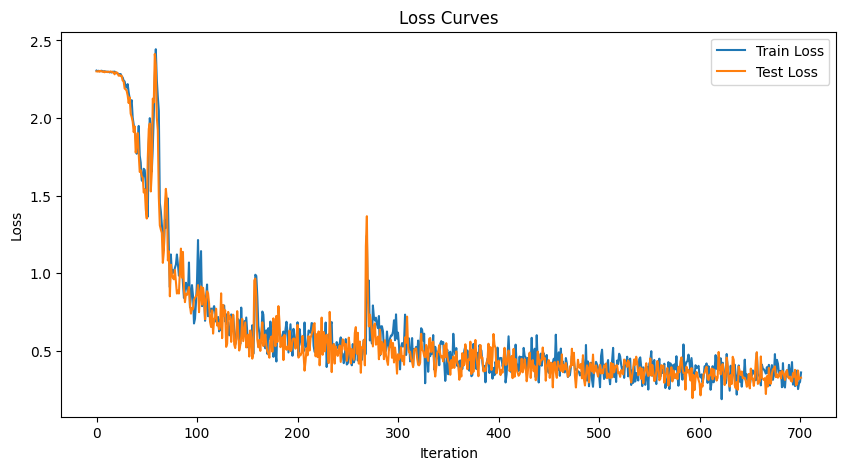

Test Set Accuracy: 90.02%


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np

DTYPE=torch.float
torch.manual_seed(734)
print("Feedforward ANN Trained on MNIST")

# setting device on GPU if available, else CPU
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device  = torch.device('cpu')
#print('Using device:', device)


# Training Parameters
batch_size=256
data_path='./tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True,drop_last=True)

############ MNIST Model ################################

# layer parameters
num_inputs = 28*28
num_hidden1 = 300   
num_hidden2 = 100
num_outputs = 10

lr=5e-1 #TODO learning rate does not directly translate from the SNN model due to the iteration steps for producing spikes
#weight_decay=1e-6

class WeightMasker(nn.Module):

    #TODO send tensors to CUDA

    def __init__(self, linearsList : nn.ModuleList, learnRate, temp = 1e-5, alpha = 1e-5, connectivity = 0.10):
        super().__init__()
        self.learnRate = learnRate
        self.regulariser = alpha * learnRate
        self.noiseTemp = temp
        self.connectivity = connectivity
        self.weightSignMasks = [] #element of 1/-1 means connection active
        self.linearsList = linearsList

        with torch.no_grad(): #is this needed?
        #initialise with weight connectivity %
            for i in self.linearsList:
                print("initial zero weights:",torch.sum(i.weight==0).item())
                weightMask = torch.bernoulli(torch.full_like(i.weight,self.connectivity,dtype=DTYPE))
                i.weight.data = i.weight * weightMask #hadamard product
                self.weightSignMasks.append( torch.sign(i.weight) * weightMask)


    def deepr_update(self):
        if not self.training: return
        with torch.no_grad():
            for i in range(len(self.linearsList)):
                (new_w,new_wsm) = self.rewiring(self.linearsList[i].weight,self.weightSignMasks[i])
                self.linearsList[i].weight.data=new_w #dont use weight = nn.Parameter, or it goes haywire
                self.weightSignMasks[i]=new_wsm

    def rewiring(self, weights: torch.tensor, weightSignMask: torch.tensor):
        #add regularisation and noise
        #weightDiff = torch.randn_like(weights,dtype=DTYPE)*((2*self.learnRate*self.noiseTemp)**0.5) - self.regulariser
        #weights = weights + weightDiff

        #remove connections below threshold
        remove_weights = ((weights * weightSignMask) >= 0)
        
        weightSignMask = weightSignMask * remove_weights

        #set disabled weights to zero
        weightMask = torch.abs(weightSignMask)
        weights = weights * weightMask

        #calculate connections to activate
        connection_count = torch.numel(weightMask)
        to_activate = int( (self.connectivity - (weightMask.sum()/connection_count) ) * connection_count )

        if to_activate>0:
            zero_indexes = torch.nonzero(weightMask == 0)

            #randomly select disabled weights
            zero_ind_ind = torch.randperm(zero_indexes.size(0))[:to_activate] #this produces indexes of the zero indexes list

            selected_weights = zero_indexes[zero_ind_ind]

            #enable weights selected with a random sign
            new_signs = ((torch.rand(to_activate) < 0.5).float() - 0.5) * 2
            weightSignMask[selected_weights[:,0],selected_weights[:,1]] = new_signs

            #assign initial values to weights equal to the learning rate
            weights[selected_weights[:,0],selected_weights[:,1]] = new_signs * self.learnRate

        return (weights, weightSignMask)

class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.linears = nn.ModuleList([
            nn.Linear(num_inputs, num_hidden1),
            nn.Linear(num_hidden1, num_hidden2),
            nn.Linear(num_hidden2, num_outputs)
        ])

        self.weightMasker = WeightMasker(self.linears,lr)

        self.neurons = nn.ModuleList([
            nn.ReLU(),
            nn.ReLU(),
            nn.ReLU()
        ])
        
    def forward(self,x):

        x = self.linears[0](x)
        x = self.neurons[0](x)
        x = self.linears[1](x)
        x = self.neurons[1](x)
        x = self.linears[2](x)

        return x


    


########### STATS ##############

def print_batch_accuracy(data, targets, train=False):
    logits = net(data.view(batch_size, -1))
    pred_probab = nn.Softmax(dim=1)(logits)
    pred = pred_probab.argmax(1)
    acc = np.mean((targets == pred).detach().cpu().numpy())
    dev = np.std((targets == pred).detach().cpu().numpy())
    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        print(f"Train set deviation for a single minibatch: {dev*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")
        print(f"Test set deviation for a single minibatch: {dev*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {img_counter}")
    print(f"Train Set Loss: {loss_hist[batch_counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[img_counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")


##############################

net = Net().to(device)
loss = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(net.parameters(),lr=lr)
scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.2, patience=5)

num_epochs = 3
loss_hist = []
test_loss_hist = []

img_counter = 0 #total no. of images iterated over

#training loop
for epoch in range(num_epochs):
    batch_counter=0 #image number within current batch

    train_batches = iter(train_loader)

    #mini-batch loop
    for data, targets in train_batches: #torch.Size([256, 1, 28, 28]), torch.Size([256])

        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train() #inform pytorch
        logits = net(data.view(batch_size, -1)) #torch.Size([256, 10])

        loss_val = loss(logits, targets)

        optimiser.zero_grad() #(reset for batch)
        loss_val.backward() #calculate backpropogation error gradient
        optimiser.step() #then update parameters

        net.weightMasker.deepr_update()

        # Store loss history for future plotting
        
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad(): #tell pytorch to disable gradient calculation (save compute)

            net.eval()
            test_data, test_targets = next(iter(test_loader)) #different test set each time due to shuffle?
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            logits = net(test_data.view(batch_size, -1))
            

            # Test set loss
            test_loss = loss(logits, test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if img_counter % 50 == 0:
                train_printer()
            img_counter += 1
            batch_counter +=1


###############################################################################################

# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    logits = net(data.view(data.size(0), -1))

    # calculate total accuracy
    pred_probab = nn.Softmax(dim=1)(logits)
    pred = pred_probab.argmax(1)
    total += targets.size(0)
    correct += (pred == targets).sum().item()

print(f"Test Set Accuracy: {100 * correct / total:.2f}%")